In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [35]:
train = pd.read_csv('data/BigMartSales_Train.csv')
test  = pd.read_csv('data/BigMartSales_Test.csv')

In [36]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Preprocessing Steps

In [37]:
# It might be more approbriate to use the combined mean as imputation value, or only the training mean
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)

Reduce the number of categorical variables

In [38]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat', 'LF'], ['Low Fat', 'Low Fat'])
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat', 'LF'], ['Low Fat', 'Low Fat'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

In [39]:
## for calculating establishment year
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year'] 
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year']

In [40]:
### missing values for size
train['Outlet_Size'].fillna('Small', inplace=True)
test['Outlet_Size'].fillna('Small', inplace=True)

In [41]:
### label encoding cate. var.
col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Fat_Content']
test['Item_Outlet_Sales'] = 0
combi = train.append(test)
number = LabelEncoder()
for i in col:
    combi.loc[:,i] = number.fit_transform(combi[i].astype('str'))
    combi.loc[:,i] = combi[i].astype('int')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

/home/jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [42]:
## removing id variables 
training = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
testing = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
y_train = training['Item_Outlet_Sales']
training.drop('Item_Outlet_Sales',axis=1,inplace=True)

# Setting up Training

In [43]:
features = training.columns
target = 'Item_Outlet_Sales'

X_train, X_test = training, testing

In [44]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [45]:
model_factory = [
 RandomForestRegressor(),
 XGBRegressor(nthread=1),
 #MLPRegressor(),
 Ridge(),
 BayesianRidge(),
 ExtraTreesRegressor(),
 ElasticNet(),
 KNeighborsRegressor(),
 GradientBoostingRegressor()
]

In [17]:
for model in model_factory:
    model.seed = 42
    num_folds = 5
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
    score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-5 RMSE: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
         ))

RandomForestRegressor     CV-5 RMSE:  1189.69 (+/- 51487.23)
XGBRegressor              CV-5 RMSE:  1083.26 (+/- 34737.98)
Ridge                     CV-5 RMSE:  1206.14 (+/- 86022.89)
BayesianRidge             CV-5 RMSE:  1206.26 (+/- 85060.48)
ExtraTreesRegressor       CV-5 RMSE:  1216.33 (+/- 29333.33)
ElasticNet                CV-5 RMSE:  1259.05 (+/- 115276.60)
KNeighborsRegressor       CV-5 RMSE:  1228.01 (+/- 65303.50)
GradientBoostingRegressor CV-5 RMSE:  1086.54 (+/- 37186.62)


The models are not tuned for simplicity.

Now lets check out the pseudo labelling

In [46]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''

    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
        from the unlabelled dataset
        ''' 
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'

        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed

        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target

    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
            }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
         )

        return self



    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)

        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])

        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels

        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)

    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)

    def get_model_name(self):
        return self.model.__class__.__name__

Let's apply the Psuedo labelling to the XGBoost Regressor

In [47]:
model_factory = [
    XGBRegressor(nthread=1),
    PseudoLabeler(
        XGBRegressor(nthread=1),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 5
 
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
    score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
     ))

XGBRegressor              CV-5 MSE: 1083.2585 (+/- 34737.9823)
PseudoLabeler             CV-5 MSE: 1082.2201 (+/- 37230.6501)


Small improvement, looks good

# Check dependence on the sampling rate

In [48]:
sample_rates = np.linspace(0, 1, 10)
def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestRegressor(n_jobs=1),
    XGBRegressor(),
]

In [51]:
# Apply the PseudoLabeler class to each model
wrapped_model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in wrapped_model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = {}
    results[model_name]['Wrapped'] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
 
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
        results[model_name]['Wrapped'].append(np.sqrt(scores.mean()*-1))
        
for model in model_factory:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
    results[model_name]["Native"] = np.sqrt(scores.mean()*-1)

RandomForestRegressor
XGBRegressor


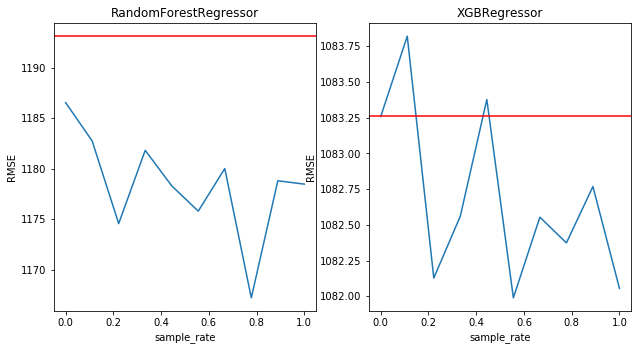

In [52]:
plt.figure(figsize=(16, 18))

i = 1
for model_name in results.keys(): 
    plt.subplot(3, 3, i)
    i += 1

    plt.plot(sample_rates, results[model_name]["Wrapped"])
    plt.axhline(y=results[model_name]["Native"], color="r")
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('RMSE')

plt.show()

Obviously the sampling rate has to be tuned, to be effective

Interestingly the effect for the random forest regressor is way bigger than for the XGBoostRegressor